In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [58]:
import os
from random import randint
import uuid,json
import matplotlib.pyplot as plt
    
from quinine import QuinineArgumentParser
from tqdm import tqdm
import torch
import yaml
import numpy as np
from eval import get_run_metrics
from tasks import get_task_sampler
from samplers import get_data_sampler
from curriculum import Curriculum
from schema_eval import schema
from schema import TASK_TO_DATA
from models import build_model
import random
from functools import wraps
from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results
from evaluate_ode import get_paras, calculate_error_stats, plot_comparison, plot_error_analysis, generate_equation_params, get_steps ,calculate_slope_map, plot_slope_heatmap, plot_error_analysis, plot_solution, calculate_mean_error_map

run_dir = "../../models12"

In [3]:
df = df = read_run_dir(run_dir)
df

run_path: ../../models12/ode_ivp_case2/9a20d467-9e5a-4883-9b98-2e4a141e55e3
run_path: ../../models12/ode_ivp_case2/83537d68-2a0b-4203-bae8-2436022f22a5
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/63c577f5-86a4-40a0-a9de-0dae6ab109c5
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/57654663-c4b8-4f5b-9336-44631ff33875
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/dfaed326-a2a7-4bc6-aff7-6e68d5ebeca2
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/15b8b341-cc45-475e-af48-4092a345f638
run_path: ../../models12/ode_ivp_case2vec_valid/a60e3ec6-223c-4b95-8fe3-8fdc0b5196da
run_path: ../../models12/ode_ivp_case2vec_valid/c80b634b-9003-4d46-998c-9985ddcd28e9
run_path: ../../models12/ode_ivp_case2vec_valid/f409869b-cfcf-4aca-bb72-454fb1b84e3c
run_path: ../../models12/ode_ivp_case2vec_valid/23aafa8d-fd90-4d39-b266-527a8e27657b
run_path: ../../models12/ode_ivp_case1plus/282a9fa2-268d-4397-a03d-fca6ce75675f
run_path: ../../models12/ode_ivp_case1/24c1872a-7ff7-427

,run_id,task,model,steps,num_tasks,num_examples,n_dims,n_layer,n_head,run_name,kwargs
17,cf0e52d6-7902-425c-8ccb-f2d52004b686,longrun_ode_ivp_case2_layer24,Transformer-12 layers,20000001,-1,-1,50,24,8,longrun_ode_ivp_case2_layer24,
26,d2f56364-4349-45ac-a123-13efa50db576,ode_ivp_case1plus_enhancedloss,Transformer,200001,-1,-1,20,12,8,ode_ivp_case1_plus_enhancedloss_run1,
20,b895f496-ad85-4545-a100-212c99ea9341,ode_ivp_case1plus_valid,Transformer,200001,-1,-1,20,12,8,ode_ivp_case1_plus_valid_run_01,
18,c3e94367-a517-47de-9eae-f74b3e1abd80,ode_ivp_case1plus_valid,Transformer,200001,-1,-1,20,12,8,ode_ivp_case1_plus_valid_run_11,
11,24c1872a-7ff7-427f-9d41-ff57d6b7ee1f,ode_ivp_case1,Transformer,500001,-1,-1,20,12,8,ode_ivp_case1_run3,
27,d99eaaaa-791d-465c-8eb3-9a44b9faa660,ode_ivp_case1plus_enhancedloss,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_enhancedloss_run_0303,
24,ac0443e1-12d4-4fe5-9f23-998216b35556,ode_ivp_case1plus_h_enhancedloss,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_enhancedloss_run_015,
15,591e2f19-6813-4881-a30f-21f4a579e8ed,ode_ivp_case1plus_h_valid,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_valid_run_01,
13,de07feef-381a-4ead-843e-3283eb5588d2,ode_ivp_case1plus_h_valid,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_valid_run_02,
14,2fde25f5-5b9d-4ff6-a914-6b28b0ea5a98,ode_ivp_case1plus_h_valid,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_valid_run_11,


In [4]:
# 选择模型
run_names = [
    "ode_ivp_case2fin_valid_layer12",
    "ode_ivp_case2fin_valid_layer24",
]
run_id = [
    "8f4129a9-d210-41fd-a0f2-4c17c633da9d",
    "9c8e476e-df17-4ebe-b7ff-b5fdaccdd063",
    ]
output_labels = [
    "ode_ivp_case2fin_valid_layer12",
    "ode_ivp_case2fin_valid_layer24",
    ]
run_paths = [os.path.join(run_dir, output_label, run_id) for run_id, output_label in zip(run_id, output_labels)]


## Out of distributions

### 1.shifted parameters

In [ ]:
# 从第一个模型中获取参数,创建任务采样器和数据采样器
_ , conf = get_model_from_run(run_paths[0])
n_dims = conf.model.n_dims
batch_size = 1
n_points = conf.training.curriculum.points.end
data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)
task = task_sampler() a1-0.7_a20.8_b1-0.6_b2-1.7_y0-0.6_te1.1

run_path: ../../models12/ode_ivp_case2fin_valid_layer12/8f4129a9-d210-41fd-a0f2-4c17c633da9d


In [6]:
allshift_xss = []
allshift_yss = []
y_models = {}
error_models = {}
rangeset = range(1, 11)
stable_para = {
    'a_1': (-1, -1),
    'a_2': (0.5, 0.5),      # 增大系数
    'b_1': (-1, -1),    # 中等强度激励项
    'b_2': (1.28, 1.28),
    'y_0': (0.5, 0.5),
    't_e': (2.0, 2.0),    # 固定时间范围
    'steps': (10, 80)      # 步数范围对应h=0.2~0.025
}
# 参数设置部分
testdata_scale_1 = 15
testdata_scale_2 = 20
shift_values_dim1 = np.linspace(-2, 2, testdata_scale_1)  # 第一维度参数变化范围
shift_values_dim2 = np.linspace(-3, 3, testdata_scale_2)  # 第二维度参数变化范围
shift_param_name1 = r'$\alpha_1$'  # 第一维度参数名
shift_param_name2 = r'$\alpha_2$'  # 第二维度参数名
savelabels = 'a_1a_2'

# 生成2D shift数据
all_shifted_xs = []  # 修改为更清晰的变量名
all_shifted_ys = []  # 修改为更清晰的变量名

for dim2_val in range(testdata_scale_2):
    xs_batch = []
    ys_batch = []
    for dim1_val in range(testdata_scale_1):
        shift_params = {
            'a_1': (shift_values_dim1[dim1_val], shift_values_dim1[dim1_val]),
            'a_2': (shift_values_dim2[dim2_val], shift_values_dim2[dim2_val]),
            'b_1': (-1, -1),
            'b_2': (1.28, 1.28),
            'y_0': (0.5, 0.5),
            't_e': (2.0, 2.0),
            'steps': (5, n_dims-5)
        }
        xs = data_sampler.continuous_sample_xs(b_size=batch_size, n_points=n_points, shifted_paras=shift_params)
        ys = task.evaluate(xs)
        xs_batch.append(xs)
        ys_batch.append(ys)
    all_shifted_xs.append(xs_batch)
    all_shifted_ys.append(ys_batch)

In [7]:
# 模型评估部分
k = 0
for run_path in tqdm(run_paths):
    model, _ = get_model_from_run(run_path)
    model.eval()
    model.cuda()
    
    with torch.no_grad():
        all_outputs = []  # 修改为更清晰的变量名
        all_errors = []   # 修改为更清晰的变量名
        
        for xs_batch, ys_batch in zip(all_shifted_xs, all_shifted_ys):
            batch_outputs = []
            batch_errors = []
            
            for xs, ys in zip(xs_batch, ys_batch):
                xs, ys = xs.cuda(), ys.cuda()
                output = model(xs, ys)
                steps = get_steps(conf.training.data, xs)
                
                # 创建mask矩阵，steps范围外设为0
                mask = torch.zeros_like(output)
                for i in range(output.shape[0]):
                    for j in range(output.shape[1]):
                        mask[i, j, :steps[i, j]] = 1

                diff = torch.abs(output - ys) * mask
                error = torch.sum(diff, dim=-1) / steps
                
                batch_outputs.append(output)
                batch_errors.append(error)
                
            all_outputs.append(batch_outputs)
            all_errors.append(batch_errors)

    y_models[run_names[k]] = all_outputs
    error_models[run_names[k]] = all_errors
    
    y_models[run_names[k]] = np.array([
        [tensor.cpu().numpy() for tensor in batch] 
        for batch in y_models[run_names[k]]
    ])
    error_models[run_names[k]] = np.array([
        [tensor.cpu().numpy() for tensor in batch] 
        for batch in error_models[run_names[k]]
    ])
    k += 1

  0%|          | 0/2 [00:00<?, ?it/s]

run_path: ../../models12/ode_ivp_case2fin_valid_layer12/8f4129a9-d210-41fd-a0f2-4c17c633da9d


 50%|█████     | 1/2 [00:03<00:03,  3.17s/it]

run_path: ../../models12/ode_ivp_case2fin_valid_layer24/9c8e476e-df17-4ebe-b7ff-b5fdaccdd063


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


In [26]:
# classic_typs = ["euler_explicit","euler_implicit","RK23","euler_improved","euler_adaptive", "BDF"]
classic_typs = ["euler_explicit","euler_implicit"] 
y_classic = {}
error_classic = {}

for typ in tqdm(classic_typs):
    task_sampler_classic = get_task_sampler(
        "ode_ivp_case2BSL",
        n_dims,
        batch_size
    )
    task_classic = task_sampler_classic()
    
    print(f"Evaluating {typ}...")
    # 修改为处理2D shift数据
    all_outputs = []
    all_errors = []

    for xs_batch, ys_batch in zip(all_shifted_xs, all_shifted_ys):
        batch_outputs = []
        batch_errors = []
        
        for xs, ys in zip(xs_batch, ys_batch):
            output = task_classic.evaluate(xs, method=typ)
            steps = get_steps(conf.training.data, xs)
            

            # 创建mask矩阵，steps范围外设为0
            mask = torch.zeros_like(output)
            for i in range(output.shape[0]):
                for j in range(output.shape[1]):
                    mask[i, j, :steps[i, j]] = 1

            diff = torch.abs(output - ys) * mask
            error = torch.sum(diff, dim=-1) / steps
            
            batch_outputs.append(output)
            batch_errors.append(error)
            
        all_outputs.append(batch_outputs)
        all_errors.append(batch_errors)
    
    # 保存结果并转换为numpy数组
    y_classic[typ] = np.array([
        [tensor.cpu().numpy() for tensor in batch] 
        for batch in all_outputs
    ])
    error_classic[typ] = np.array([
        [tensor.cpu().numpy() for tensor in batch] 
        for batch in all_errors
    ])

  0%|          | 0/2 [00:00<?, ?it/s]

Evaluating euler_explicit...


 50%|█████     | 1/2 [00:04<00:04,  4.26s/it]

Evaluating euler_implicit...


100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


In [ ]:
print(error_models[run_names[0]].shape)
print(error_models[run_names[0]][0,0,:,:])
viemw = all_shifted_xs[0][0][:,:,6]
print(viemw)

(20, 15, 1, 41)
[[496.83185 344.38815 368.5742  275.0843  241.7184  238.28947 257.9779
  258.16968 275.21085 319.46652 352.67587 351.60275 329.71304 284.55713
  287.5035  295.8317  293.50882 288.47556 267.02313 226.24425 182.8174
  172.31339 180.33849 161.49939 147.42816 138.10158 138.88309 144.4896
  157.48386 167.54782 151.83469 166.61621 214.71187 191.2553  170.29395
  148.45255 184.1234  222.37512 204.72955 190.64975 151.04092]]
tensor([[ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
         19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.,
         33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45.]],
       device='cuda:0')


In [29]:
print(y_classic[classic_typs[0]].shape)
print(error_classic[classic_typs[0]][0,0,:,:])
print(error_classic[classic_typs[0]].shape)
# print(error_classic[classic_typs[0]][0,0,:,:])

(20, 15, 1, 41, 50)
[[392.5357   338.49176  301.85205  275.38     255.27219  239.3722
  226.38261  215.4842   206.13824  197.9779   190.74586  184.25667
  178.37357  172.99353  168.03745  163.44351  159.16272  155.15553
  151.38972  147.83864  144.48004  141.2951   138.2678   135.38437
  132.63286  130.00278  127.48496  125.07129  122.754486 120.52809
  118.386246 116.323715 114.3357   112.417854 110.566154 108.777016
  107.04704  105.37315  103.752464 102.18235  100.66033 ]]
(20, 15, 1, 41)


In [10]:
# 保存评估结果路径
fig_dir_raw = "../figs"
print(f"Save figures to {fig_dir_raw}")

Save figures to ../figs


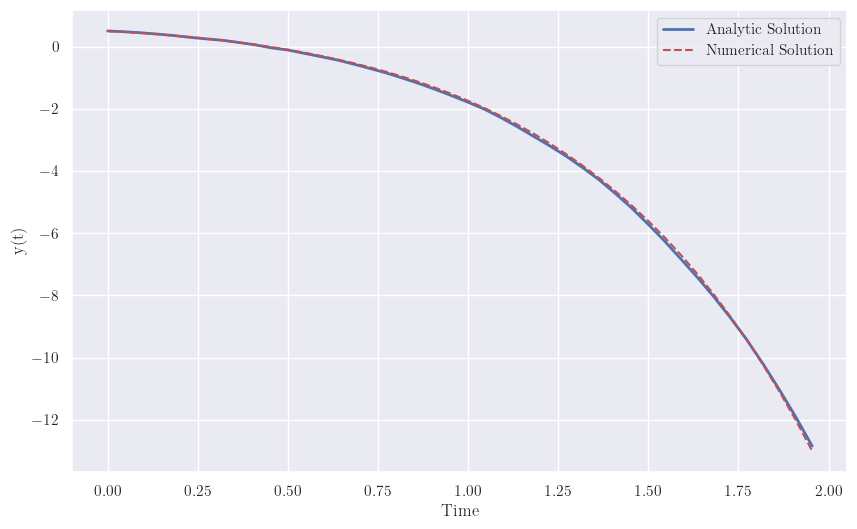

In [57]:
equation_title, filename_params, h_full, steps_full = generate_equation_params(conf, xs, n_points,0)
plot_solution(all_shifted_xs[7][7], all_shifted_ys[7][7], y_models[run_names[0]][7,7,:,:], conf.training.data, 0, 40,save_path=os.path.join(fig_dir_raw,'2dshift_errormap' f"{classic_typs[0]}shift2d_plot_{filename_params}.pdf"))

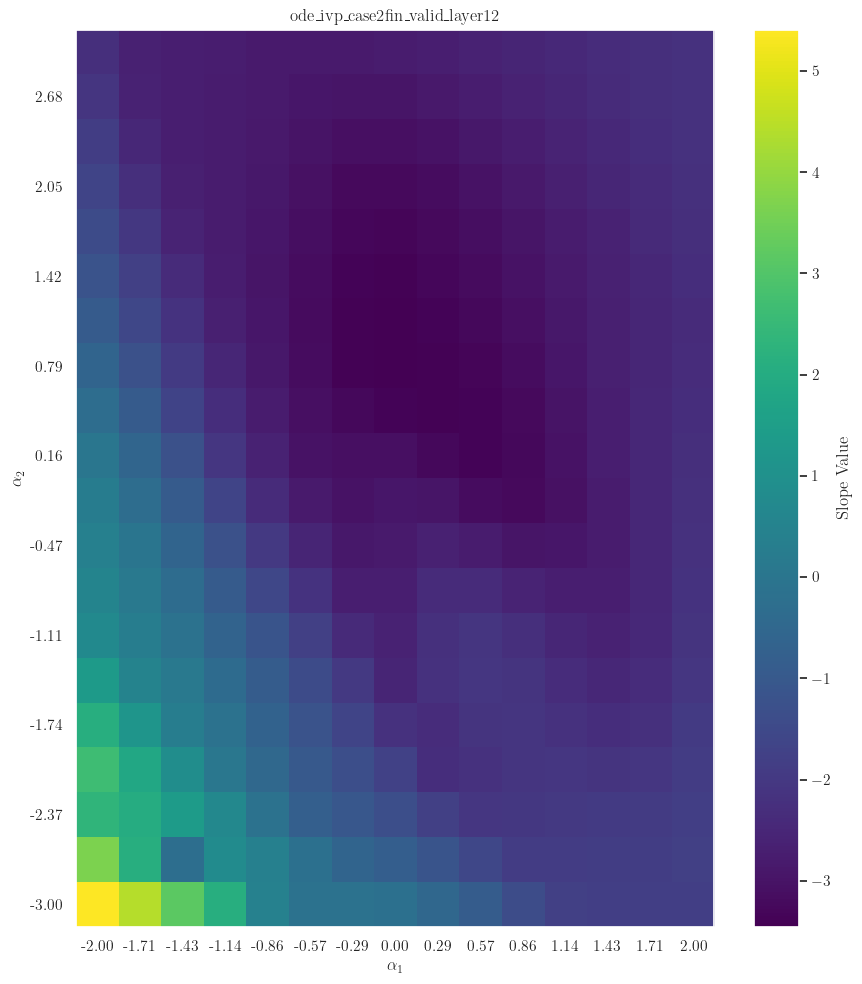

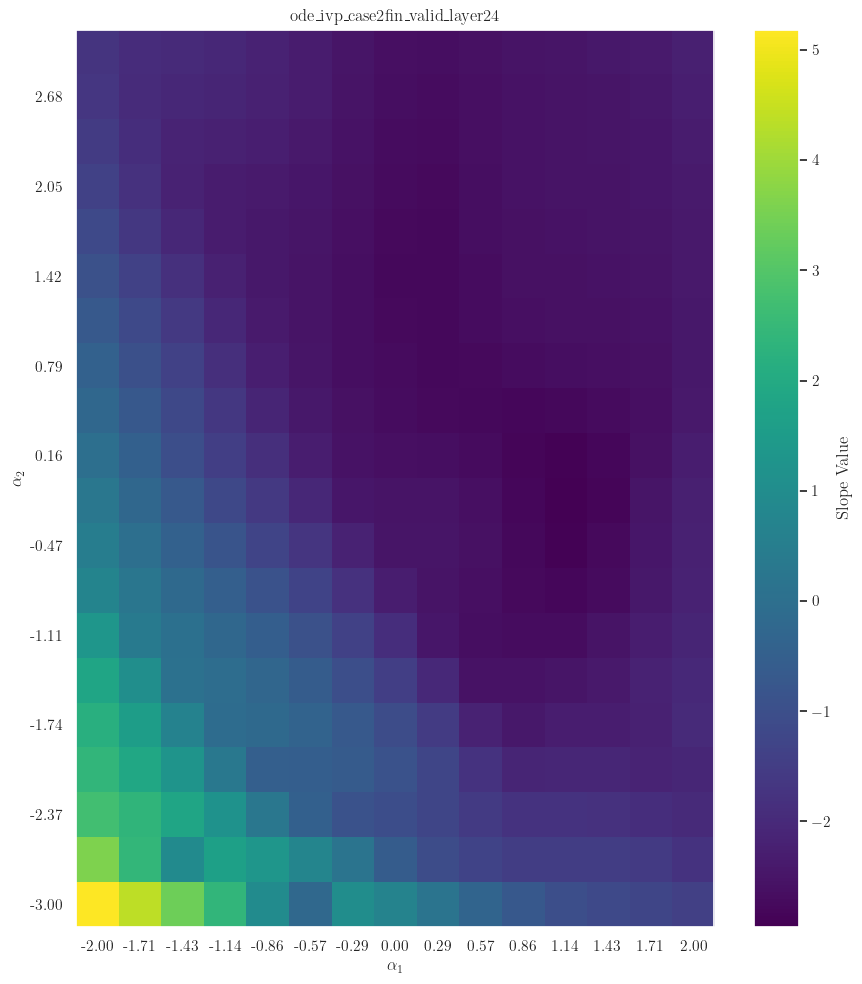

In [60]:
for key, value in error_models.items():
    errortable = calculate_mean_error_map(value)
    plot_slope_heatmap(errortable,
                        f'{key}',
                        shift_param_name1,
                        shift_param_name2,
                        shift_values_dim1,
                        shift_values_dim2,
                        os.path.join(fig_dir_raw,'2dshift_errormap',f'{key}_{savelabels}error_map.pdf'))

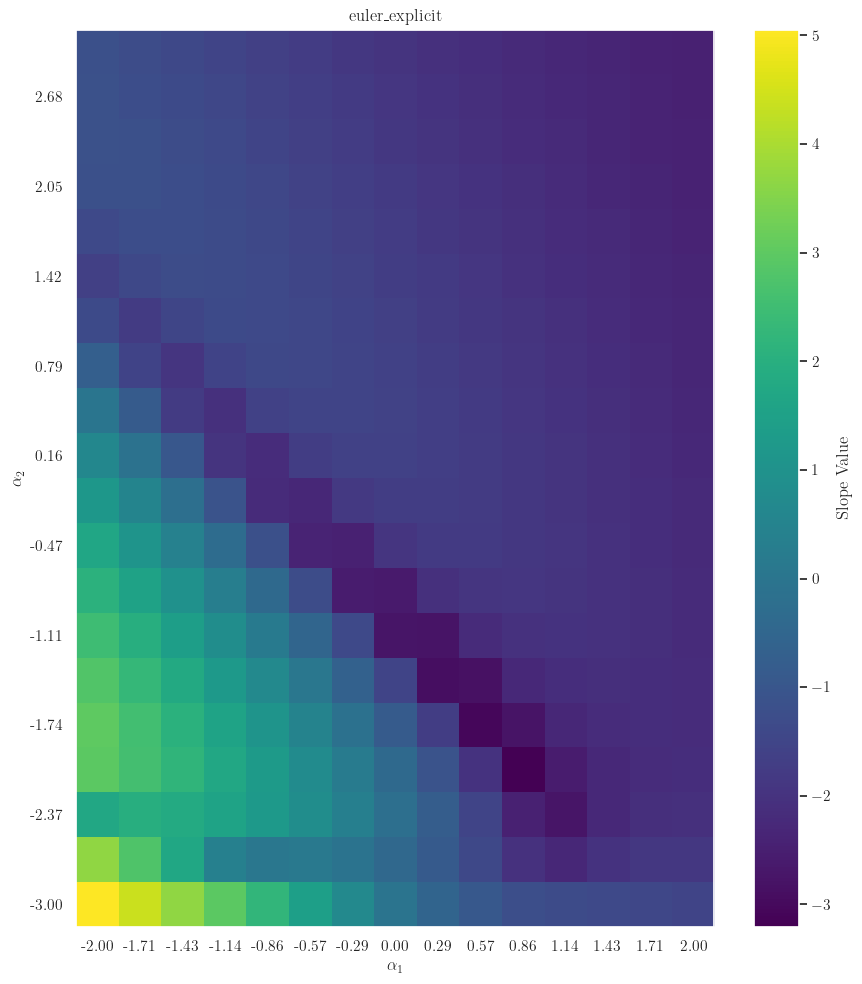

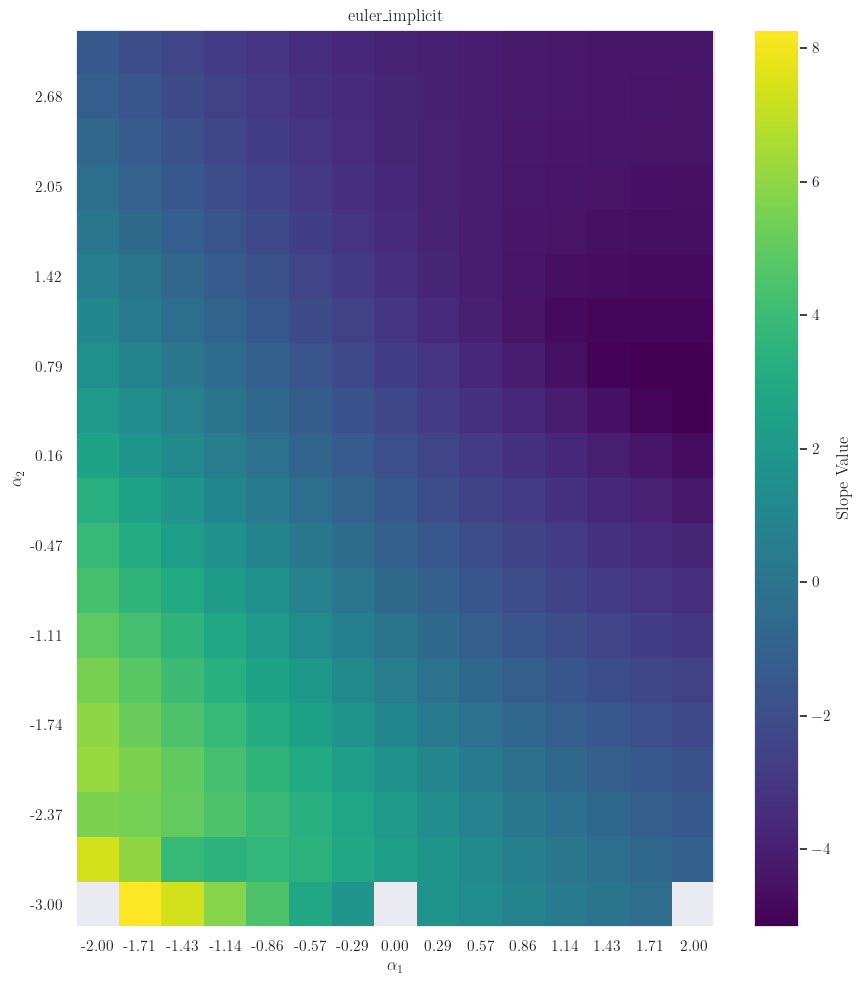

In [61]:
for key, value in error_classic.items():
    errortable = calculate_mean_error_map(value)
    plot_slope_heatmap(errortable,
                        f'{key}',
                        shift_param_name1,
                        shift_param_name2,
                        shift_values_dim1,
                        shift_values_dim2,
                        os.path.join(fig_dir_raw,'2dshift_errormap',f'{key}_{savelabels}error_map.pdf'))

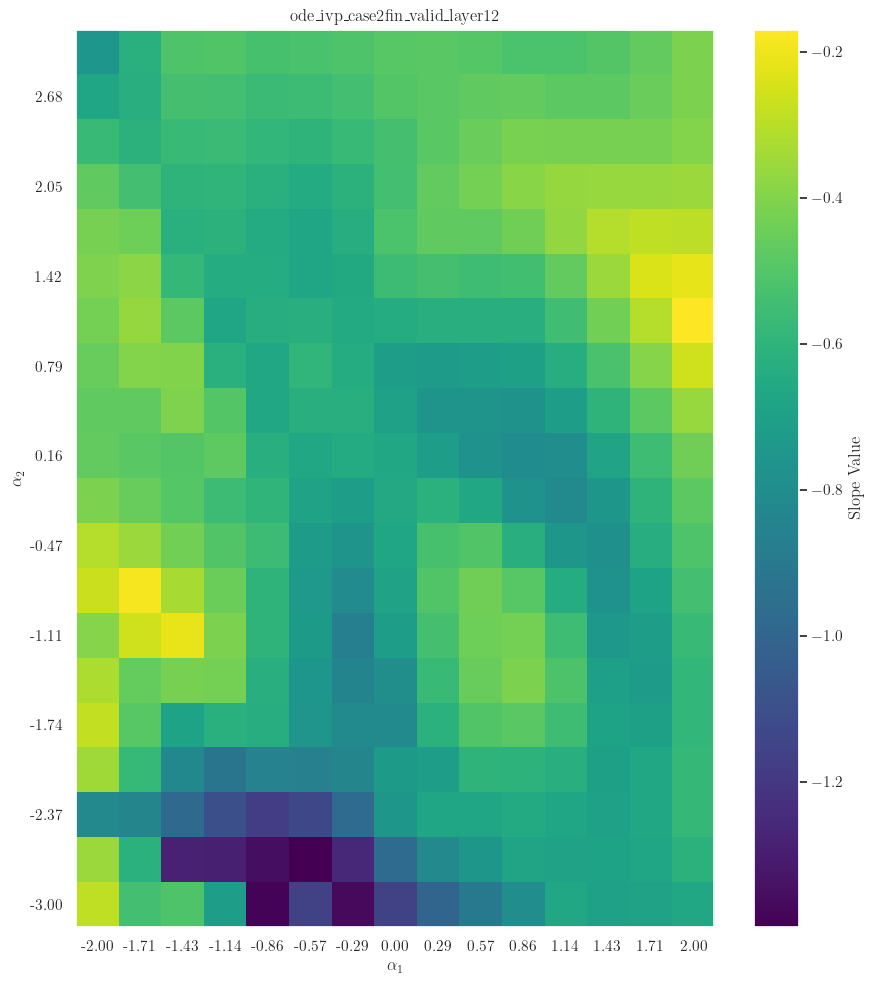

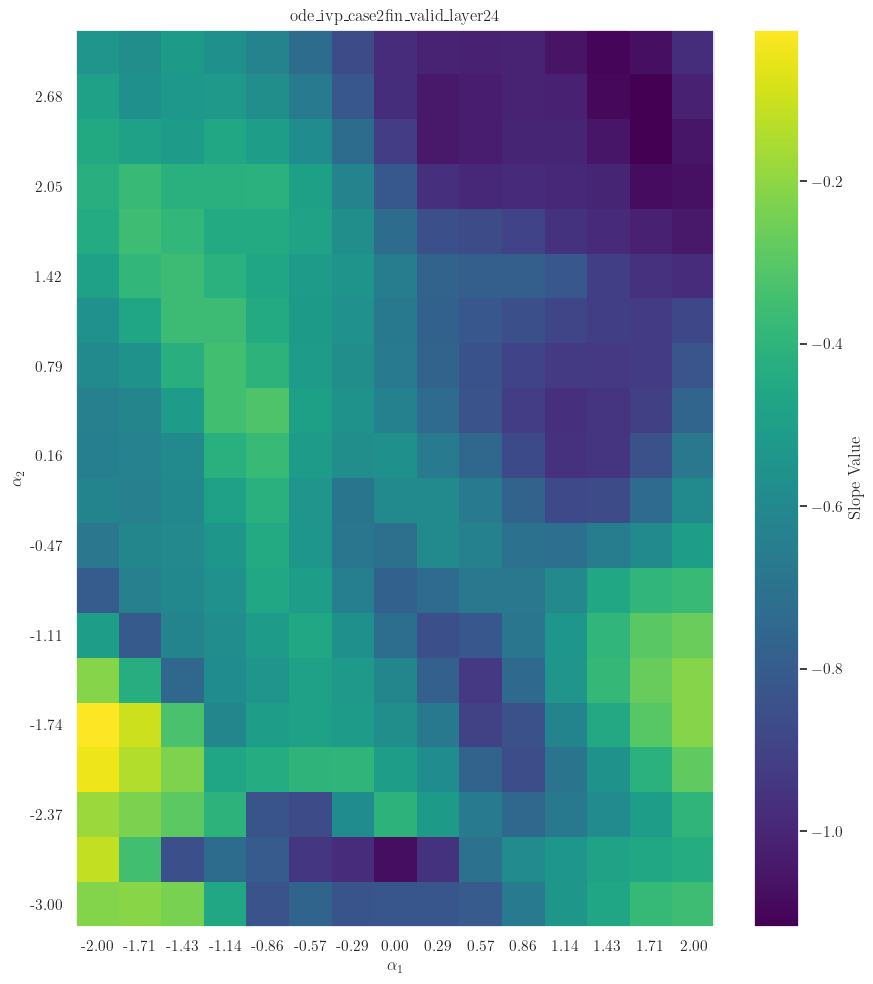

In [ ]:
for key, value in error_models.items():
    slopetable = calculate_slope_map(value)
    plot_slope_heatmap(slopetable,
                        f'{key}',
                        shift_param_name1,
                        shift_param_name2,
                        shift_values_dim1,
                        shift_values_dim2,
                        os.path.join(fig_dir_raw,'2dshift_slopemap',f'{key}_{savelabels}slope_map.pdf'))

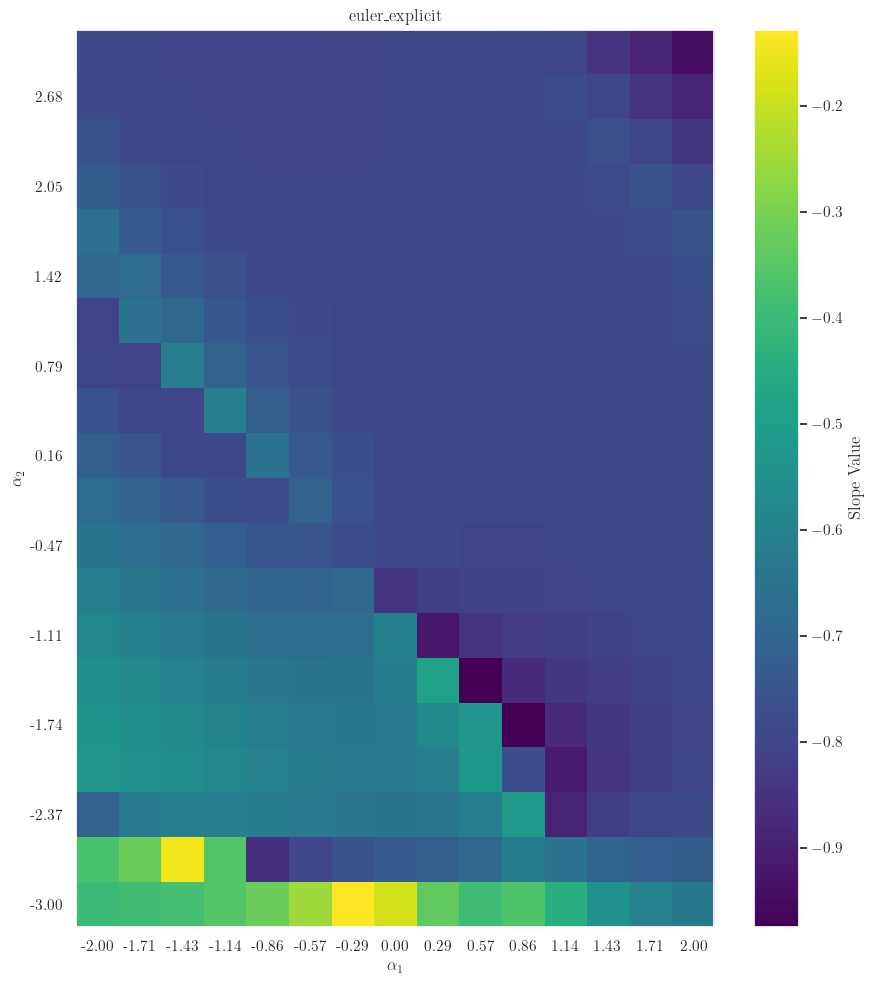

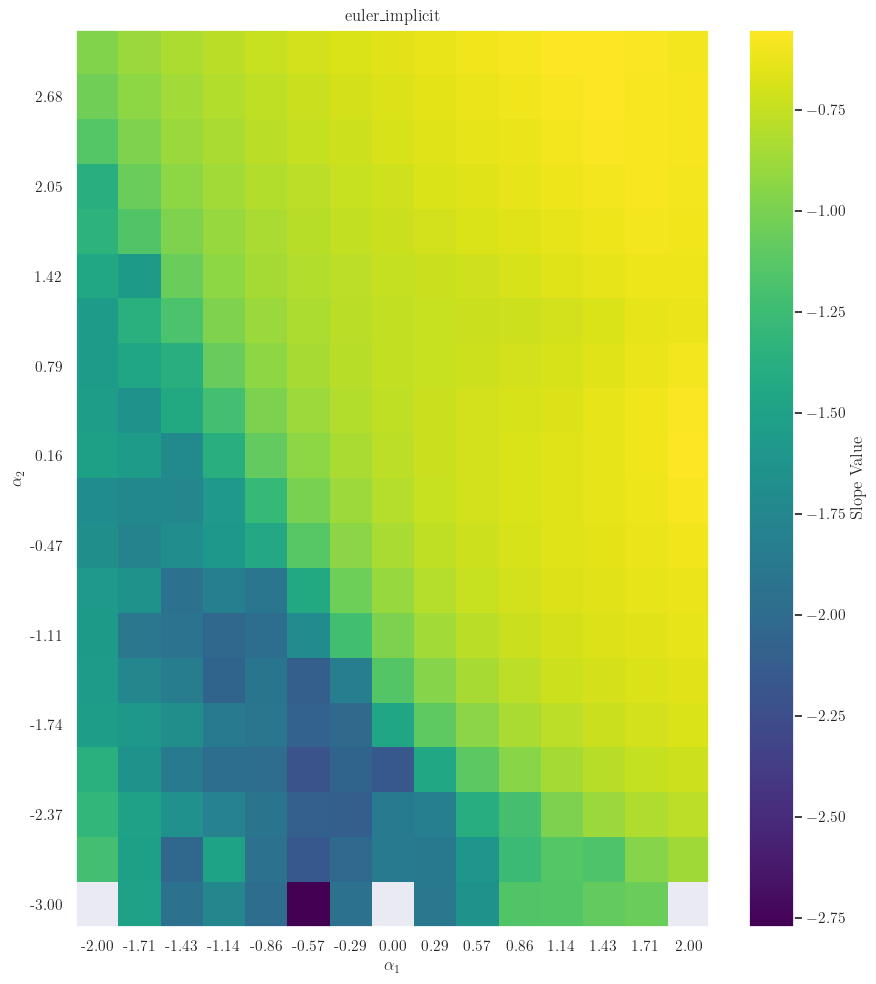

In [51]:
for key, value in error_classic.items():
    slopetable = calculate_slope_map(value)
    plot_slope_heatmap(slopetable, f'{key}',shift_param_name1,shift_param_name2,shift_values_dim1,shift_values_dim2, os.path.join(fig_dir_raw,'2dshift_slopemap',f'{key}_{savelabels}slope_map.pdf'))

#### 画图

In [12]:
stepshape = allshift_xss[0][:,:,6].cpu().numpy()
plt.imshow(stepshape, cmap='viridis', interpolation='nearest')
plt.colorbar()  
plt.title(f'Heatmap ')
plt.show()

IndexError: list index out of range

In [ ]:
# log_error_classic = {
#     'euler_explicit': np.log(error_classic['euler_explicit']),
#     'euler_implicit': np.log(error_classic['euler_implicit']),
#     }
log_error_models = {
    }
log_error_models = {key: np.log(value) for key, value in error_models.items()}
error_models

{'ode_ivp_case2fin_valid_layer12': array([[[2.6387417 , 2.0811405 , 2.008831  , ..., 1.8315185 ,
          1.8321533 , 1.8216438 ],
         [2.6387417 , 2.0811405 , 2.008831  , ..., 1.8315185 ,
          1.8321533 , 1.8216438 ],
         [2.6387417 , 1.896874  , 1.9834813 , ..., 1.8744462 ,
          1.8687536 , 1.8659703 ],
         ...,
         [2.6387417 , 1.896874  , 1.2305726 , ..., 0.7801287 ,
          0.8399719 , 4.5328383 ],
         [2.6387417 , 1.896874  , 1.2305726 , ..., 0.7801287 ,
          0.8399719 , 4.5328383 ],
         [2.6387417 , 1.896874  , 1.2305726 , ..., 0.7801287 ,
          0.8399719 , 4.5328383 ]],
 
        [[1.7479827 , 1.5466286 , 1.4394914 , ..., 1.2986592 ,
          1.2974222 , 1.2927444 ],
         [1.7479827 , 1.5466286 , 1.4394914 , ..., 1.2986592 ,
          1.2974222 , 1.2927444 ],
         [1.7479827 , 1.2108274 , 1.2421368 , ..., 1.1970396 ,
          1.2002691 , 1.1957169 ],
         ...,
         [1.7479827 , 1.2108274 , 0.97648233, ..., 0.

ode_ivp_case2fin_valid_layer12


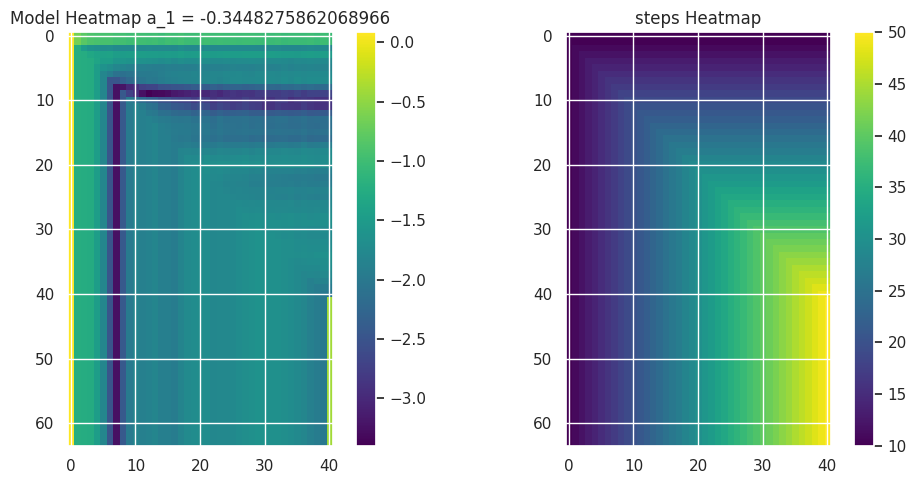

ode_ivp_case2fin_valid_layer24


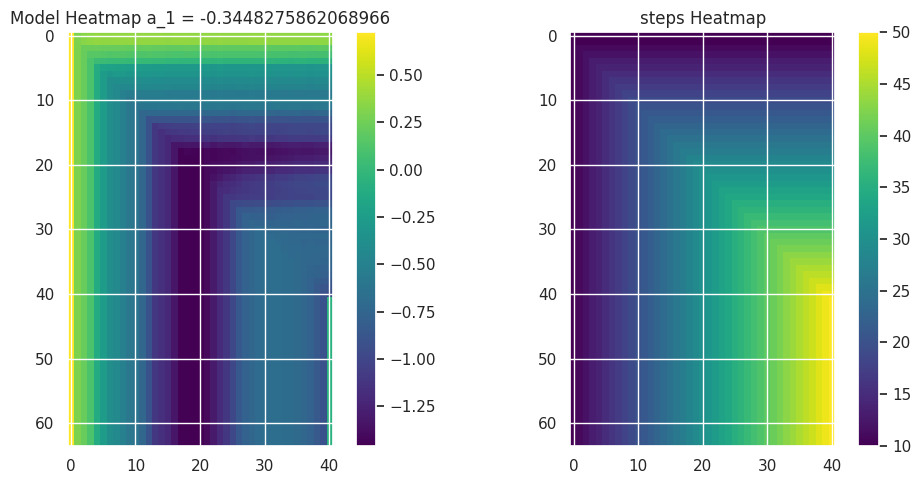

In [ ]:
ind = 12
fig_dir_base = fig_dir_raw
for key, value in log_error_models.items():
    print(key)
    fig_dir = os.path.join(fig_dir_base, key)
# 确保图片目录存在
    os.makedirs(fig_dir, exist_ok=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    equation_title, filename_params, h_full, steps_full = generate_equation_params(conf, xs, n_points)
    # 
    data1 = value[ind]
    # data1 = log_error_classic['euler_explicit'][ind]
    im1 = ax1.imshow(data1, cmap='viridis', interpolation='nearest')
    fig.colorbar(im1, ax=ax1)
    ax1.set_title(f'Model Heatmap {shiftvaluename} = {shiftvalues[ind]}')

    # 第二张热图
    im2 = ax2.imshow(stepshape, cmap='viridis', interpolation='nearest')
    fig.colorbar(im2, ax=ax2)
    ax2.set_title(f'steps Heatmap')

    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"log_error_heatmap_{shiftvaluename}_{filename_params}.png"))
    plt.show()
fig_dir = fig_dir_base


(30, 41)


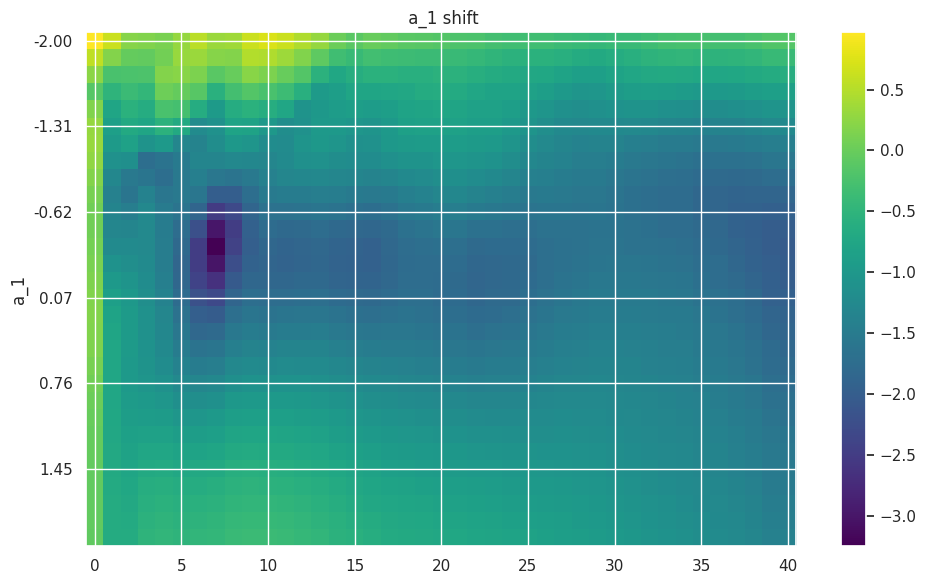

(30, 41)


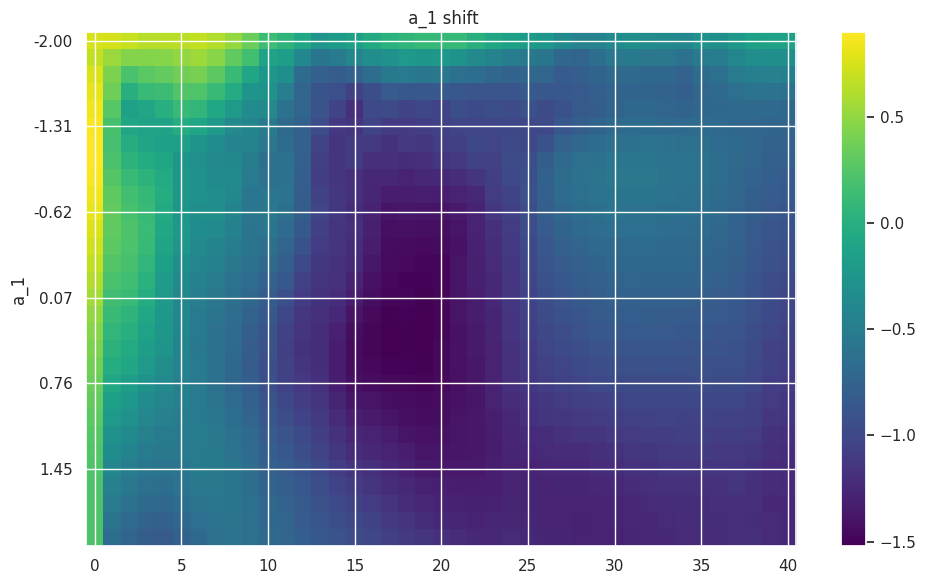

In [ ]:
special_npoints = 40
fig_dir_base = fig_dir_raw
for key, value in log_error_models.items():
    data = value[:,40,:]
    print(data.shape)
    fig_dir = os.path.join(fig_dir_base, key)
    plt.figure(figsize=(10, 6))
    im = plt.imshow(data, cmap='viridis', interpolation='nearest', aspect='auto')

    # 设置横轴刻度为shiftvalues
    tick_step = 5  # 设置刻度间隔
    plt.yticks(range(0, len(shiftvalues), tick_step), 
            [f"{shiftvalues[i]:.2f}" for i in range(0, len(shiftvalues), tick_step)])
    plt.ylabel(f'{shiftvaluename}')

    plt.colorbar(im)  # 添加颜色条以显示数值范围
    plt.title(f' {shiftvaluename} shift')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"{shiftvaluename}_shift_log_error_{filename_params}_npoints_{special_npoints}.png"))
    plt.show()